---
# 1. Setup & Installation

## 1.1 Install Dependencies

In [34]:
# Install dependencies (NOT Astromer - will clone repo instead)
!pip install -q extinction==0.4.7
# !pip install -q tensorflow>=2.14
# !pip install -q scikit-learn
!pip install -q optuna
!pip install -q catboost

# Clone Astromer repository
!git clone https://github.com/astromer-science/main-code.git astromer_repo 2>/dev/null || echo "Repo already cloned"

# Add to Python path
import sys
sys.path.insert(0, '/kaggle/working/astromer_repo/src')

print("✓ Dependencies installed")
print("✓ Astromer repo cloned")

✓ Dependencies installed
✓ Astromer repo cloned


## 1.2 Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import pickle
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Extinction correction
from extinction import fitzpatrick99

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, precision_recall_curve, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# For later stages
# import astromer  # Will be used after installation

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

## 1.3 Setup Paths

In [3]:
# Kaggle paths (adjust for local testing)
BASE_PATH = "/kaggle/input/mallorn-dataset"
WORKING_DIR = "/kaggle/working"

# Create output directories
PREPROCESSED_DIR = f"{WORKING_DIR}/preprocessed_data"
EMBEDDINGS_DIR = f"{WORKING_DIR}/embeddings"
MODELS_DIR = f"{WORKING_DIR}/models"
CHECKPOINTS_DIR = f"{WORKING_DIR}/checkpoints"

for dir_path in [PREPROCESSED_DIR, EMBEDDINGS_DIR, MODELS_DIR, CHECKPOINTS_DIR]:
    os.makedirs(dir_path, exist_ok=True)

print("Directories created:")
print(f"  - Preprocessed data: {PREPROCESSED_DIR}")
print(f"  - Embeddings: {EMBEDDINGS_DIR}")
print(f"  - Models: {MODELS_DIR}")
print(f"  - Checkpoints: {CHECKPOINTS_DIR}")

Directories created:
  - Preprocessed data: /kaggle/working/preprocessed_data
  - Embeddings: /kaggle/working/embeddings
  - Models: /kaggle/working/models
  - Checkpoints: /kaggle/working/checkpoints


---
# 2. Data Preprocessing Pipeline

## 2.1 Load Metadata

In [4]:
# Load train/test metadata
train_df = pd.read_csv(f"{BASE_PATH}/train_log.csv")
test_df = pd.read_csv(f"{BASE_PATH}/test_log.csv")

print(f"Training objects: {len(train_df)}")
print(f"Test objects: {len(test_df)}")
print(f"\nClass distribution:")
print(train_df['target'].value_counts())
print(f"\nImbalance ratio: {train_df['target'].value_counts()[0] / train_df['target'].value_counts()[1]:.1f}:1")

Training objects: 3043
Test objects: 7135

Class distribution:
target
0    2895
1     148
Name: count, dtype: int64

Imbalance ratio: 19.6:1


## 2.2 Define Preprocessing Functions

In [5]:
# Constants
BANDS = ['u', 'g', 'r', 'i', 'z', 'y']
EFF_WAVELENGTHS = {
    "u": 3641, "g": 4704, "r": 6155, 
    "i": 7504, "z": 8695, "y": 10056
}
R_V = 3.1
MAX_OBSERVATIONS = 200  # Astromer input length
FLUX_ZERO = 1.0  # Softening flux for asinh magnitudes (μJy)
ZERO_POINT = 23.9  # AB magnitude zero point for μJy

def flux_to_magnitude(flux, flux_err):
    """
    Convert flux (μJy) to Asinh magnitude
    
    Standard approach for handling negative flux measurements:
    m_asinh = -2.5/ln(10) * asinh(flux / (2*flux_0)) + zero_point
    
    This function is well-defined for negative flux and smoothly
    transitions through zero, preserving information about
    negative measurements (common in astronomical data).
    
    Reference: Lupton et al. 1999, AJ 118:1406
    
    Args:
        flux: Flux in microjanskys (can be negative)
        flux_err: Flux uncertainty in microjanskys
    
    Returns:
        magnitude: Asinh magnitude
        magnitude_error: Propagated magnitude error
    """
    # Asinh magnitude - well-defined for negative flux
    b = 2 * FLUX_ZERO  # Softening parameter = 2 μJy
    magnitude = -2.5 / np.log(10) * np.arcsinh(flux / b) + ZERO_POINT
    
    # Error propagation for asinh magnitude:
    # dm/df = (2.5 / ln(10)) * (1/b) / sqrt(1 + (f/b)^2)
    mag_err = (2.5 / np.log(10)) * (flux_err / b) / np.sqrt(1 + (flux / b)**2)
    
    return magnitude, mag_err

def correct_extinction(flux, flux_err, filter_name, ebv):
    """
    Apply extinction correction using Fitzpatrick99 law
    
    Note: This preserves the sign of flux (negative flux remains negative)
    which is physically correct for background-subtracted measurements.
    
    Returns corrected flux and error
    """
    wavelength = EFF_WAVELENGTHS[filter_name]
    A_lambda = fitzpatrick99(np.array([wavelength]), ebv * R_V)[0]
    scale = 10 ** (A_lambda / 2.5)
    
    flux_true = flux * scale
    flux_err_true = flux_err * scale
    
    return flux_true, flux_err_true

def pad_or_truncate(time, mag, mag_err, max_len=MAX_OBSERVATIONS):
    """
    Pad (with zeros) or truncate light curve to fixed length
    
    For truncation: Uses peak-centered window strategy optimal for TDE detection.
    Finds the brightness peak (minimum magnitude) and extracts a window around it,
    preserving the most informative temporal features (rise, peak, early decay).
    
    Returns:
        padded arrays, mask array (1=real, 0=padded)
    """
    n_obs = len(time)
    
    if n_obs == 0:
        # Completely empty band - return all zeros
        return (
            np.zeros(max_len),
            np.zeros(max_len),
            np.zeros(max_len),
            np.zeros(max_len, dtype=bool)
        )
    
    if n_obs >= max_len:
        # Truncate - use peak-centered window
        # Find peak (minimum magnitude = brightest point)
        peak_idx = np.argmin(mag)
        
        # Calculate window boundaries centered on peak
        half_window = max_len // 2
        start_idx = max(0, peak_idx - half_window)
        end_idx = min(n_obs, peak_idx + half_window)
        
        # Adjust if window hits boundary
        if end_idx - start_idx < max_len:
            if start_idx == 0:
                end_idx = min(n_obs, start_idx + max_len)
            else:
                start_idx = max(0, end_idx - max_len)
        
        # Extract window
        indices = np.arange(start_idx, start_idx + max_len)
        return (
            time[indices],
            mag[indices],
            mag_err[indices],
            np.ones(max_len, dtype=bool)
        )
    else:
        # Pad with zeros
        time_padded = np.zeros(max_len)
        mag_padded = np.zeros(max_len)
        mag_err_padded = np.zeros(max_len)
        mask = np.zeros(max_len, dtype=bool)
        
        time_padded[:n_obs] = time
        mag_padded[:n_obs] = mag
        mag_err_padded[:n_obs] = mag_err
        mask[:n_obs] = True
        
        return time_padded, mag_padded, mag_err_padded, mask

def normalize_lightcurve(time, mag, mag_err, mask, redshift):
    """
    Apply zero-mean normalization (Astromer requirement)
    + Rest-frame time correction for time dilation
    Only normalize over real observations (mask=True)
    
    Args:
        redshift: Cosmological redshift (z) for time dilation correction
                  t_rest = t_obs / (1 + z)
    """
    if mask.sum() == 0:
        return time, mag, mag_err
    
    # Normalize only real observations
    time_norm = time.copy()
    mag_norm = mag.copy()
    mag_err_norm = mag_err.copy()
    
    # Zero-mean normalization + rest-frame correction
    # Time dilation: observed time = rest time × (1 + z)
    # So: rest time = observed time / (1 + z)
    time_norm[mask] = (time[mask] - time[mask].mean()) / (1 + redshift)
    mag_norm[mask] = mag[mask] - mag[mask].mean()
    # Don't normalize errors - keep original scale
    
    return time_norm, mag_norm, mag_err_norm

## 2.3 Process Light Curves

In [6]:
def preprocess_object(object_id, split, ebv, redshift, is_train=True):
    """
    Preprocess a single object:
    1. Load light curve
    2. Apply extinction correction
    3. Convert flux to magnitude
    4. Split by bands
    5. Pad/truncate to 200 observations
    6. Normalize (with rest-frame time correction for redshift)
    
    Args:
        redshift: Cosmological redshift (z) for time dilation correction
    
    Returns:
        Dictionary with keys: 'u', 'g', 'r', 'i', 'z', 'y'
        Each value is dict: {'time': array, 'mag': array, 'mag_err': array, 'mask': array}
    """
    # Load light curve
    filename = "train_full_lightcurves.csv" if is_train else "test_full_lightcurves.csv"
    lc_path = f"{BASE_PATH}/{split}/{filename}"
    
    try:
        lc_df = pd.read_csv(lc_path)
        lc_df = lc_df[lc_df['object_id'] == object_id]
    except Exception as e:
        print(f"Error loading {object_id}: {e}")
        return None
    
    result = {}
    
    for band in BANDS:
        band_df = lc_df[lc_df['Filter'] == band].copy()
        
        if len(band_df) == 0:
            # Empty band - all zeros
            result[band] = {
                'time': np.zeros(MAX_OBSERVATIONS),
                'mag': np.zeros(MAX_OBSERVATIONS),
                'mag_err': np.zeros(MAX_OBSERVATIONS),
                'mask': np.zeros(MAX_OBSERVATIONS, dtype=bool)
            }
            continue
        
        # Sort by time
        band_df = band_df.sort_values('Time (MJD)')
        
        # Apply extinction correction
        flux_true, flux_err_true = correct_extinction(
            band_df['Flux'].values,
            band_df['Flux_err'].values,
            band,
            ebv
        )
        
        # Convert to magnitude
        mag, mag_err = flux_to_magnitude(flux_true, flux_err_true)
        
        # Handle invalid values
        valid_mask = np.isfinite(mag) & np.isfinite(mag_err)
        time = band_df['Time (MJD)'].values[valid_mask]
        mag = mag[valid_mask]
        mag_err = mag_err[valid_mask]
        
        # Pad/truncate
        time_pad, mag_pad, mag_err_pad, mask = pad_or_truncate(time, mag, mag_err)
        
        # Normalize (with rest-frame correction for time dilation)
        time_norm, mag_norm, mag_err_norm = normalize_lightcurve(
            time_pad, mag_pad, mag_err_pad, mask, redshift
        )
        
        result[band] = {
            'time': time_norm,
            'mag': mag_norm,
            'mag_err': mag_err_norm,
            'mask': mask
        }
    
    return result

# Test on a few objects
print("Testing preprocessing on sample objects...")
sample_ids = train_df.sample(3)

for idx, row in sample_ids.iterrows():
    processed = preprocess_object(row['object_id'], row['split'], row['EBV'], row['Z'], is_train=True)
    if processed:
        print(f"\n{row['object_id']} (target={row['target']}, z={row['Z']:.3f}):")
        for band in BANDS:
            n_real = processed[band]['mask'].sum()
            print(f"  {band}: {n_real}/200 real observations")

Testing preprocessing on sample objects...

nagol_amdir_aranarth (target=0, z=1.067):
  u: 8/200 real observations
  g: 6/200 real observations
  r: 18/200 real observations
  i: 20/200 real observations
  z: 28/200 real observations
  y: 24/200 real observations

alagos_honeg_bragol (target=0, z=1.119):
  u: 8/200 real observations
  g: 7/200 real observations
  r: 23/200 real observations
  i: 20/200 real observations
  z: 20/200 real observations
  y: 17/200 real observations

baug_tavor_pent (target=0, z=0.406):
  u: 11/200 real observations
  g: 13/200 real observations
  r: 40/200 real observations
  i: 47/200 real observations
  z: 38/200 real observations
  y: 27/200 real observations


## 2.4 Batch Process All Objects

In [7]:
def process_all_objects(df, is_train=True, save=True):
    """
    Process all objects and save to disk
    
    Returns:
        Dictionary mapping object_id -> processed data
    """
    all_data = {}
    failed = []
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {'train' if is_train else 'test'}"):
        object_id = row['object_id']
        processed = preprocess_object(object_id, row['split'], row['EBV'], row['Z'], is_train)
        
        if processed is None:
            failed.append(object_id)
            continue
        
        all_data[object_id] = processed
    
    if failed:
        print(f"\nFailed to process {len(failed)} objects: {failed[:10]}...")
    
    # Save to disk
    if save:
        dataset_name = "train" if is_train else "test"
        save_path = f"{PREPROCESSED_DIR}/{dataset_name}_preprocessed.pkl"
        
        with open(save_path, 'wb') as f:
            pickle.dump(all_data, f)
        
        print(f"Saved {len(all_data)} objects to {save_path}")
        print(f"File size: {os.path.getsize(save_path) / (1024**2):.1f} MB")
    
    return all_data

# Process training data
print("Processing training data...")
train_data = process_all_objects(train_df, is_train=True, save=True)

# Process test data
print("\nProcessing test data...")
test_data = process_all_objects(test_df, is_train=False, save=True)

Processing training data...


Processing train:   0%|          | 0/3043 [00:00<?, ?it/s]

Saved 3043 objects to /kaggle/working/preprocessed_data/train_preprocessed.pkl
File size: 89.6 MB

Processing test data...


Processing test:   0%|          | 0/7135 [00:00<?, ?it/s]

Saved 7135 objects to /kaggle/working/preprocessed_data/test_preprocessed.pkl
File size: 210.2 MB


## 2.5 Verify Preprocessing Quality

Analyzing training data preprocessing:


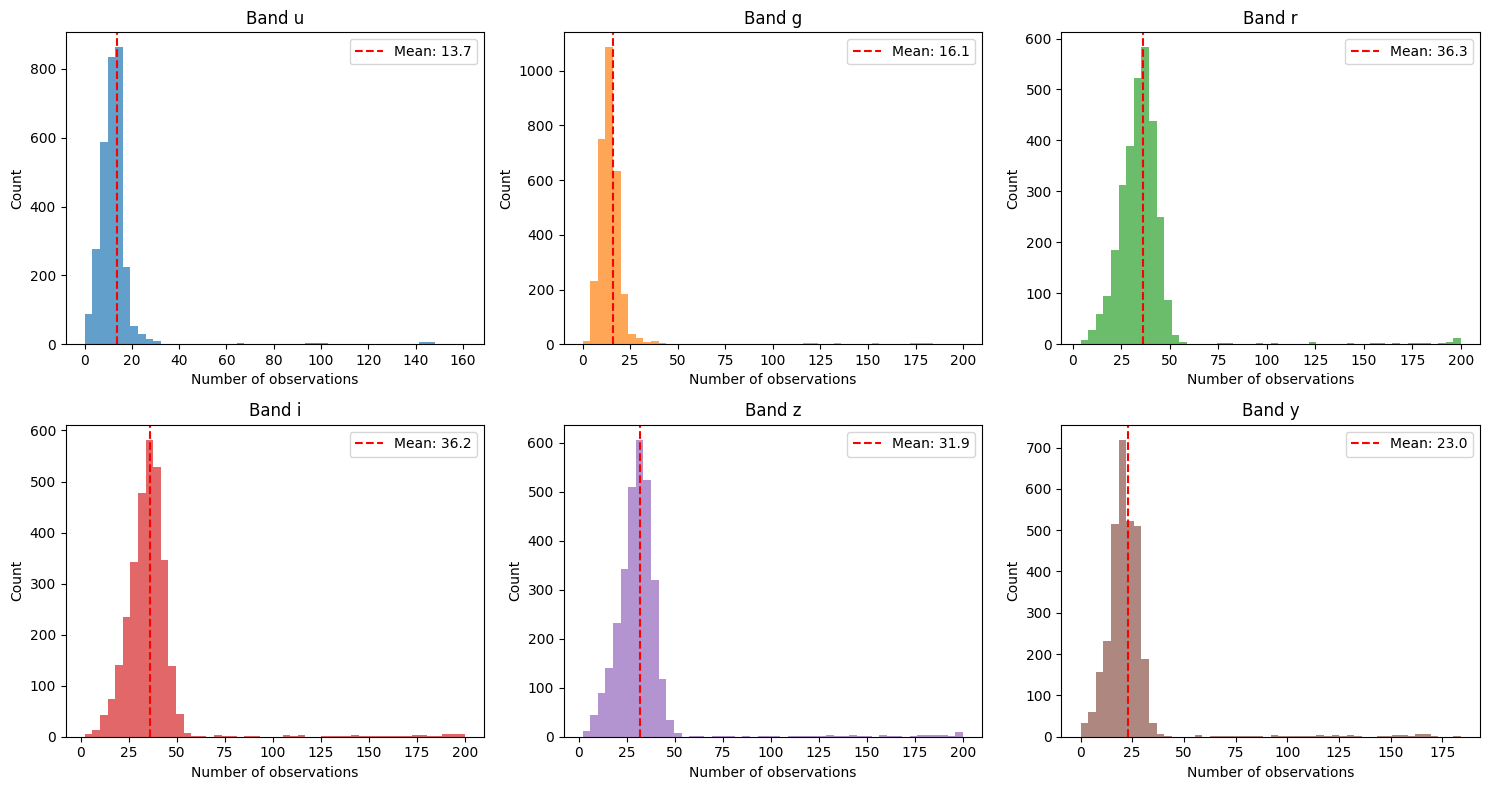


Observations per band (mean ± std):
  u: 13.7 ± 15.9 (min: 0, max: 161)
  g: 16.1 ± 19.0 (min: 0, max: 200)
  r: 36.3 ± 20.1 (min: 4, max: 200)
  i: 36.2 ± 19.5 (min: 2, max: 200)
  z: 31.9 ± 20.1 (min: 2, max: 200)
  y: 23.0 ± 17.1 (min: 0, max: 184)

Objects with no observations in any band: 0


Analyzing test data preprocessing:


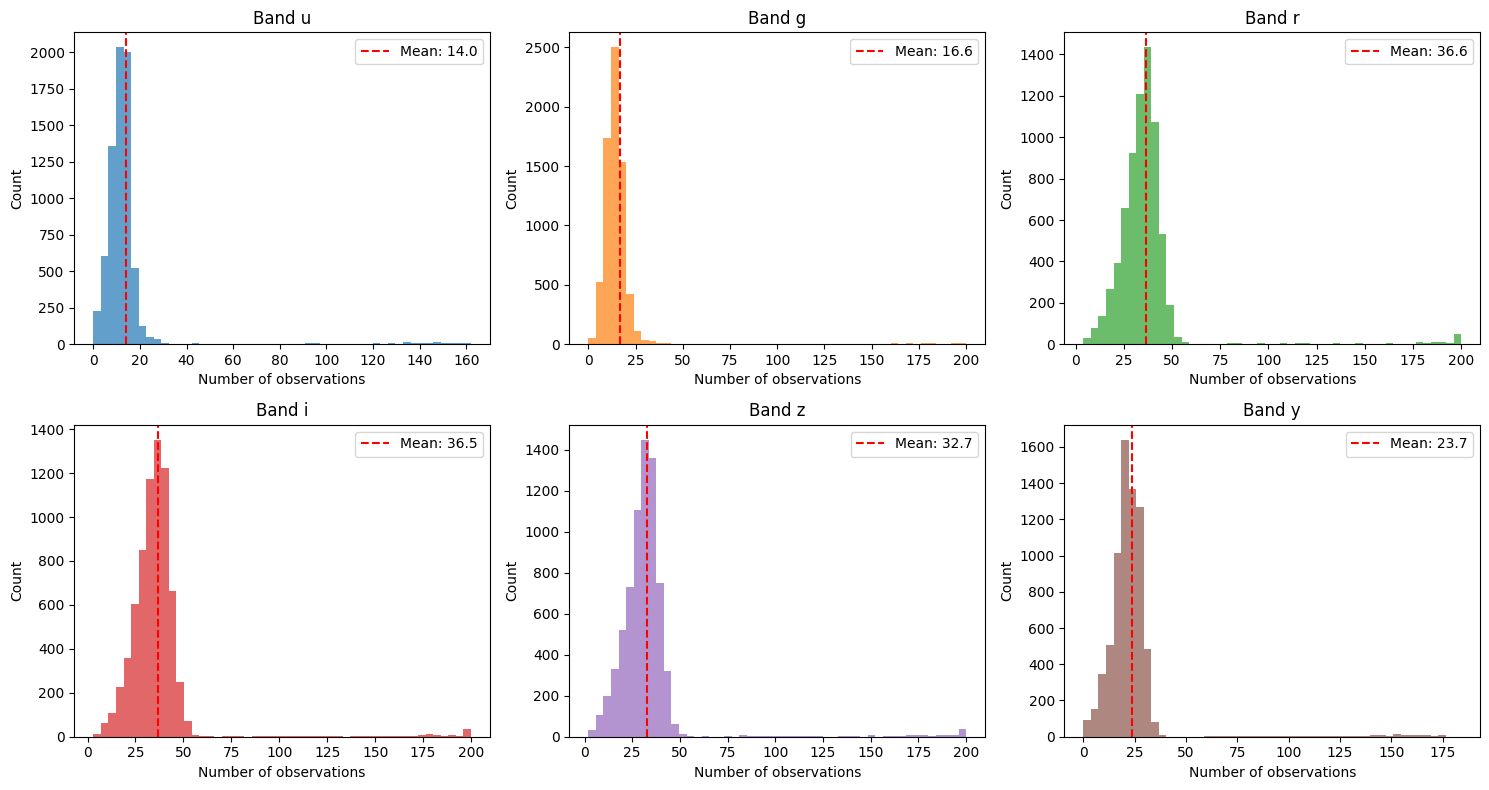


Observations per band (mean ± std):
  u: 14.0 ± 17.5 (min: 0, max: 162)
  g: 16.6 ± 20.9 (min: 0, max: 200)
  r: 36.6 ± 21.8 (min: 4, max: 200)
  i: 36.5 ± 20.9 (min: 3, max: 200)
  z: 32.7 ± 21.9 (min: 2, max: 200)
  y: 23.7 ± 18.4 (min: 0, max: 184)

Objects with no observations in any band: 0


In [8]:
# Analyze preprocessing results
def analyze_preprocessing(data_dict, df):
    """
    Analyze processed data quality
    """
    band_obs_counts = {band: [] for band in BANDS}
    
    for object_id, processed in data_dict.items():
        for band in BANDS:
            n_obs = processed[band]['mask'].sum()
            band_obs_counts[band].append(n_obs)
    
    # Plot distribution
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()
    
    for idx, band in enumerate(BANDS):
        counts = band_obs_counts[band]
        axes[idx].hist(counts, bins=50, alpha=0.7, color=f'C{idx}')
        axes[idx].set_title(f'Band {band}')
        axes[idx].set_xlabel('Number of observations')
        axes[idx].set_ylabel('Count')
        axes[idx].axvline(np.mean(counts), color='red', linestyle='--', 
                         label=f'Mean: {np.mean(counts):.1f}')
        axes[idx].legend()
    
    plt.tight_layout()
    plt.savefig(f'{WORKING_DIR}/preprocessing_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print statistics
    print("\nObservations per band (mean ± std):")
    for band in BANDS:
        counts = band_obs_counts[band]
        print(f"  {band}: {np.mean(counts):.1f} ± {np.std(counts):.1f} "
              f"(min: {np.min(counts)}, max: {np.max(counts)})")
    
    # Check for completely empty objects
    empty_count = sum(1 for obj_data in data_dict.values() 
                     if all(obj_data[b]['mask'].sum() == 0 for b in BANDS))
    print(f"\nObjects with no observations in any band: {empty_count}")

print("Analyzing training data preprocessing:")
analyze_preprocessing(train_data, train_df)

print("\n" + "="*80 + "\n")

print("Analyzing test data preprocessing:")
analyze_preprocessing(test_data, test_df)

## 2.6 Visualize Sample Preprocessed Light Curves

Visualizing TDE examples:


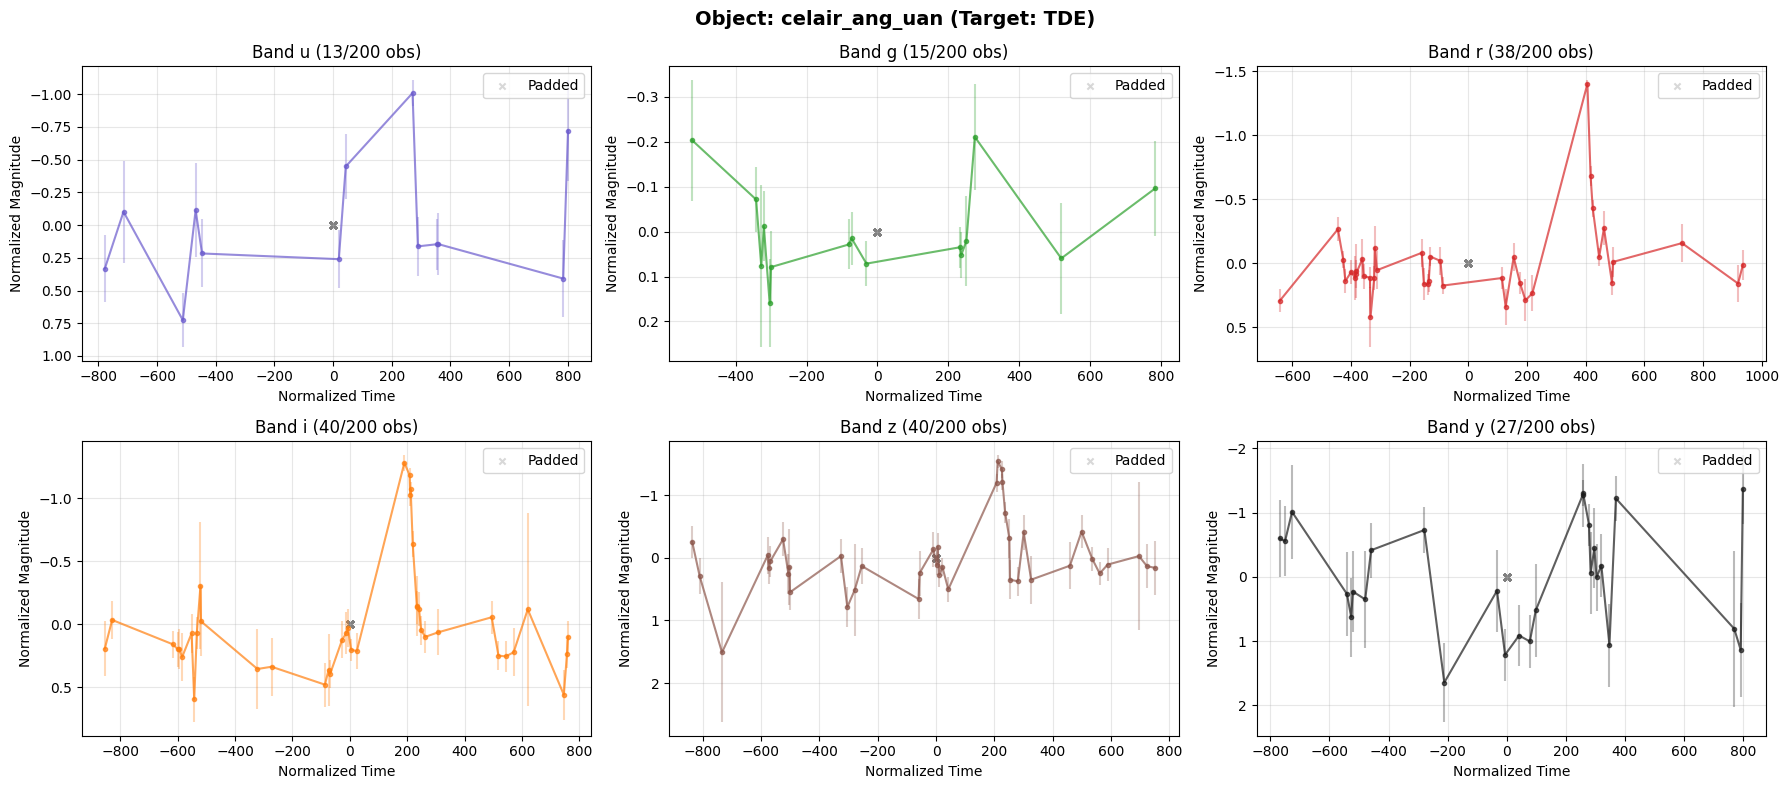

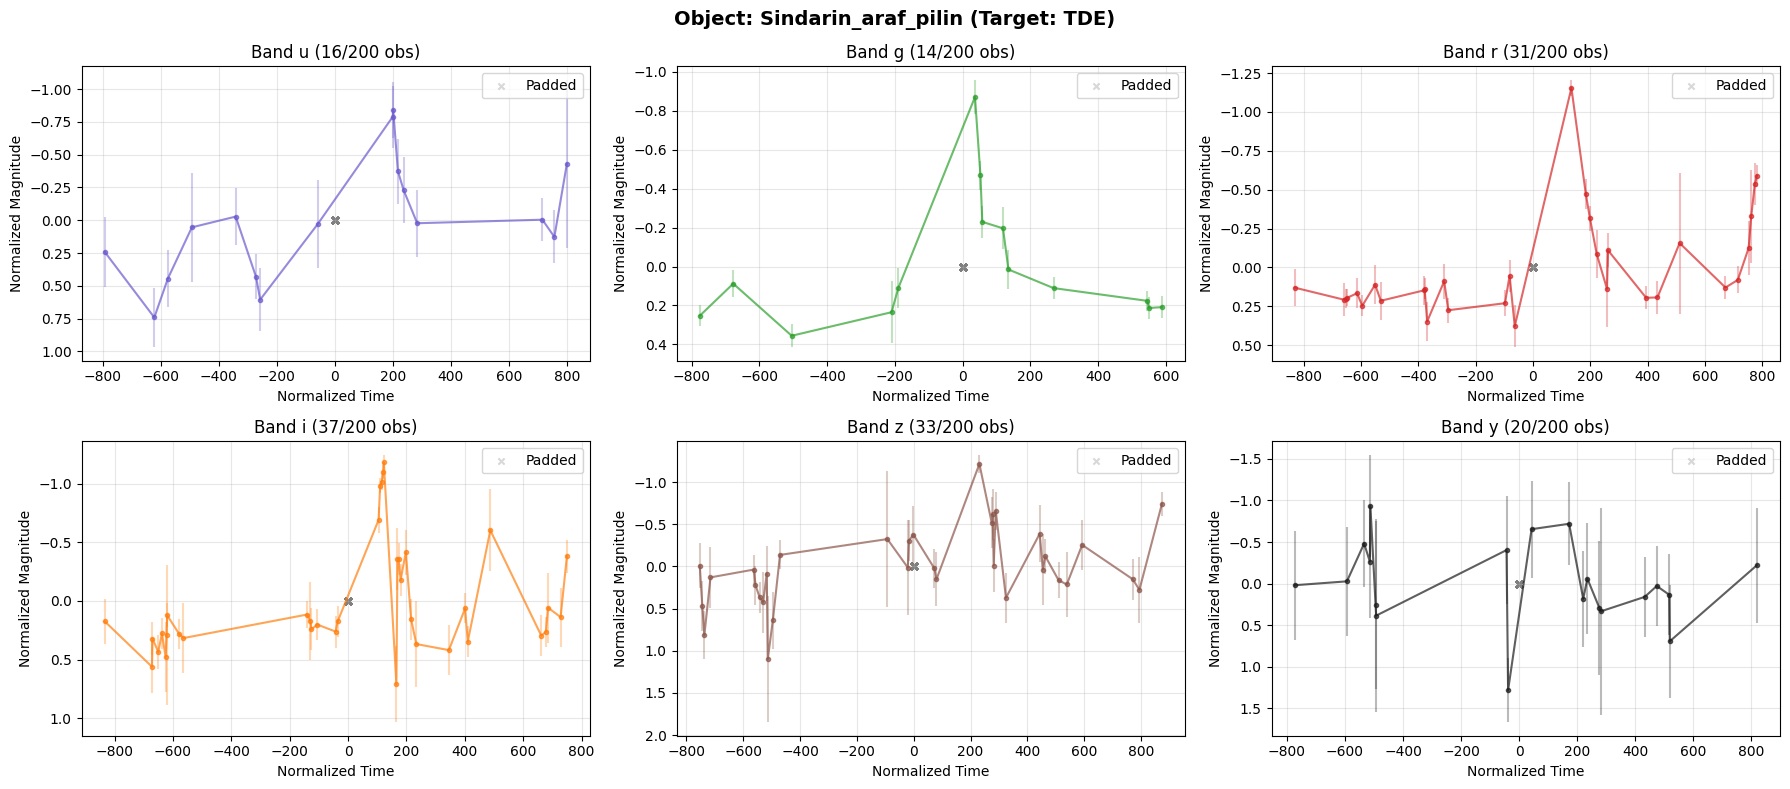

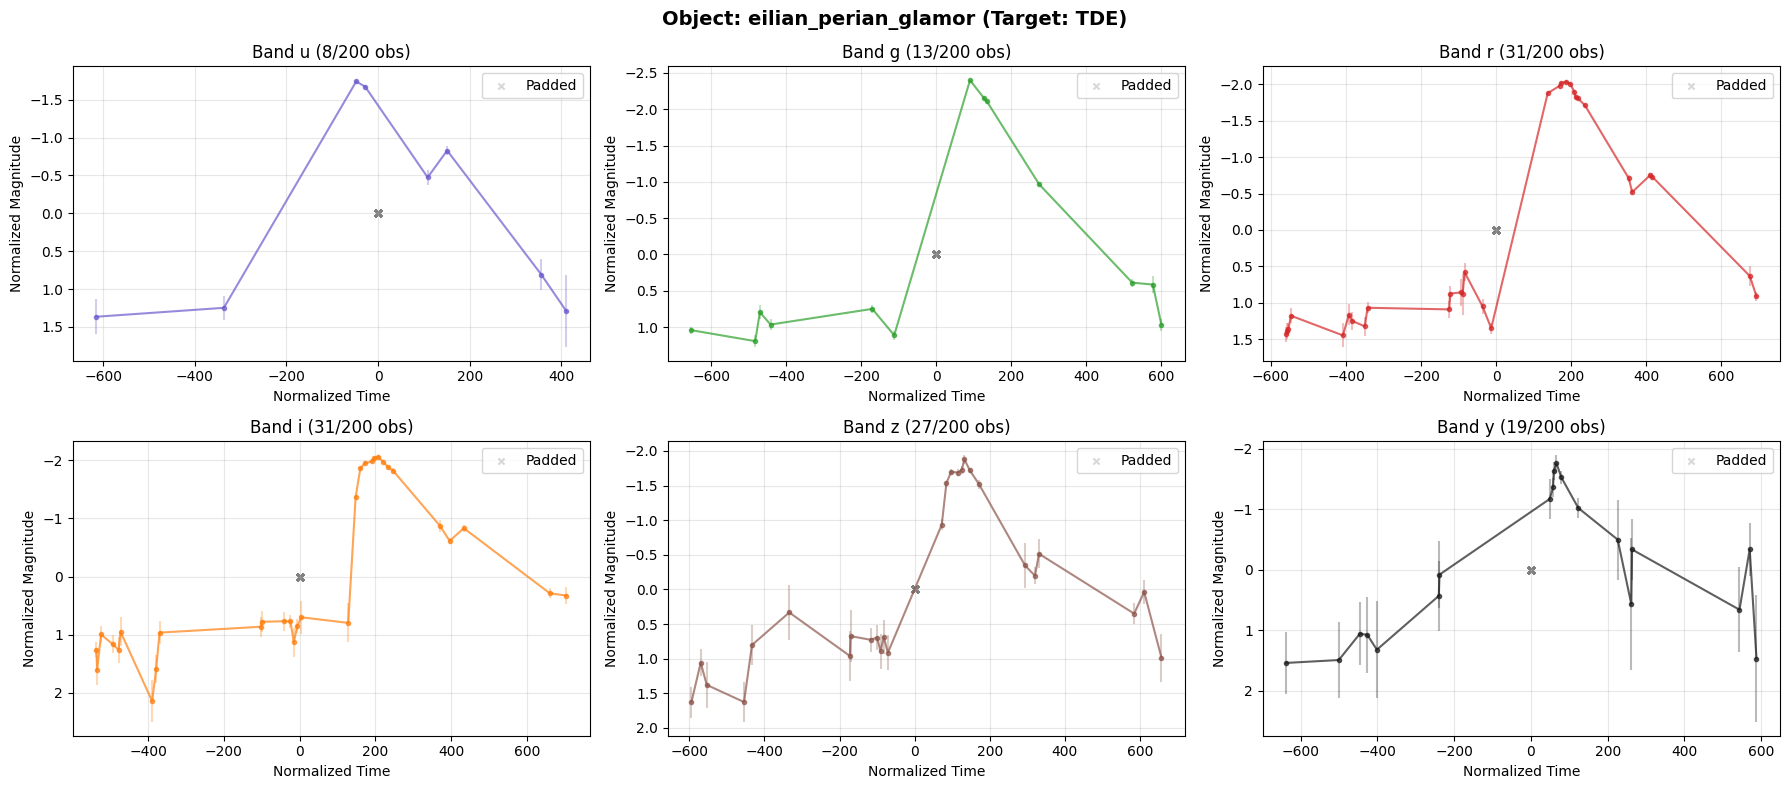


Visualizing Non-TDE examples:


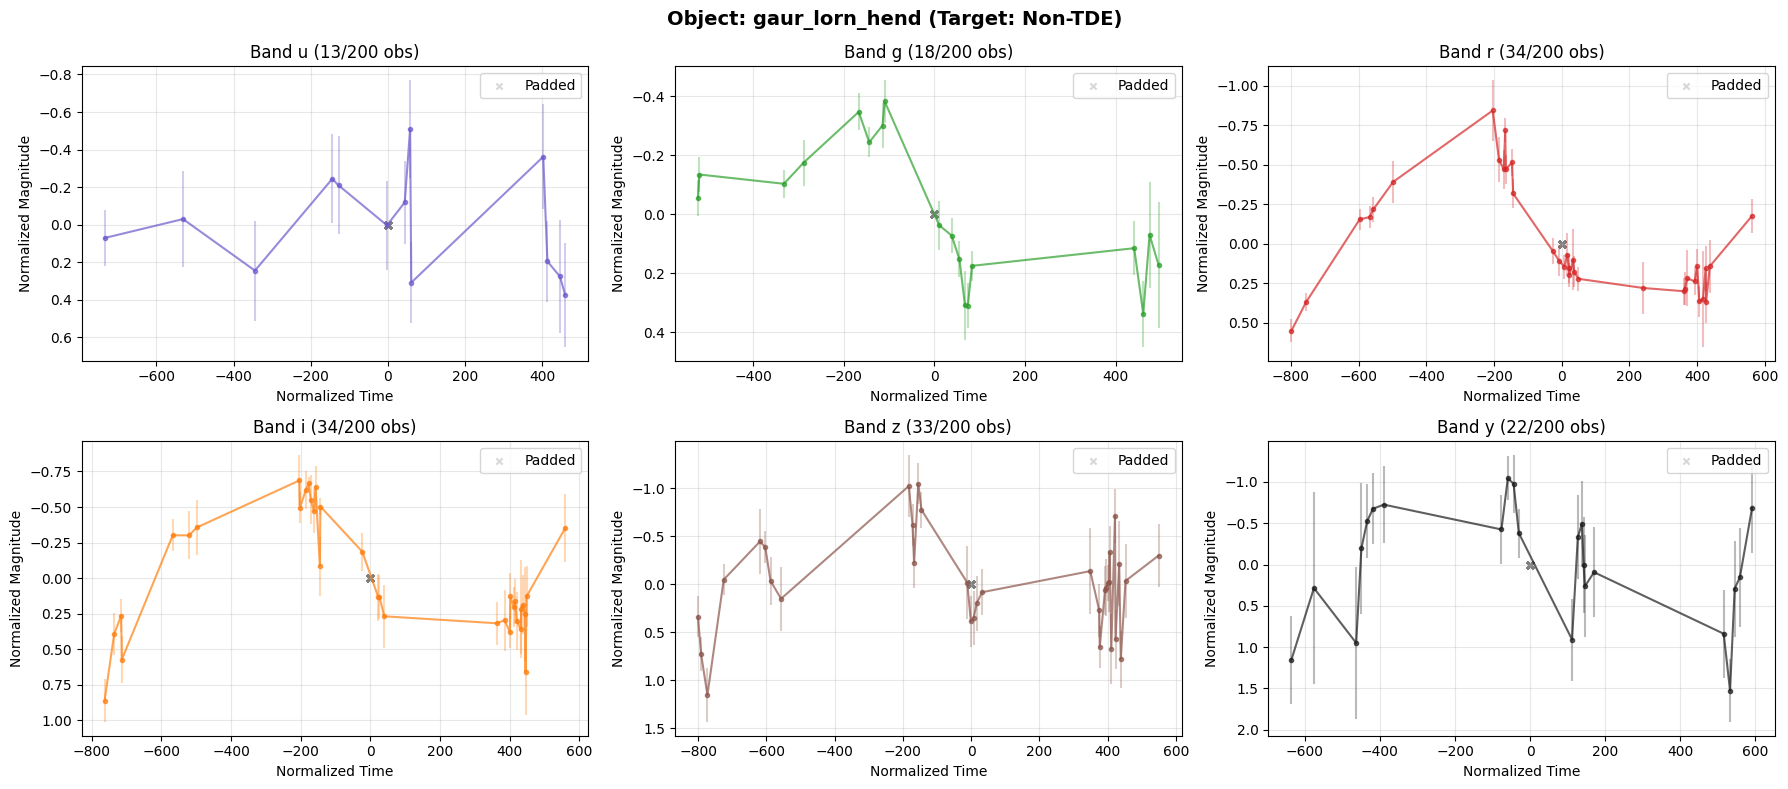

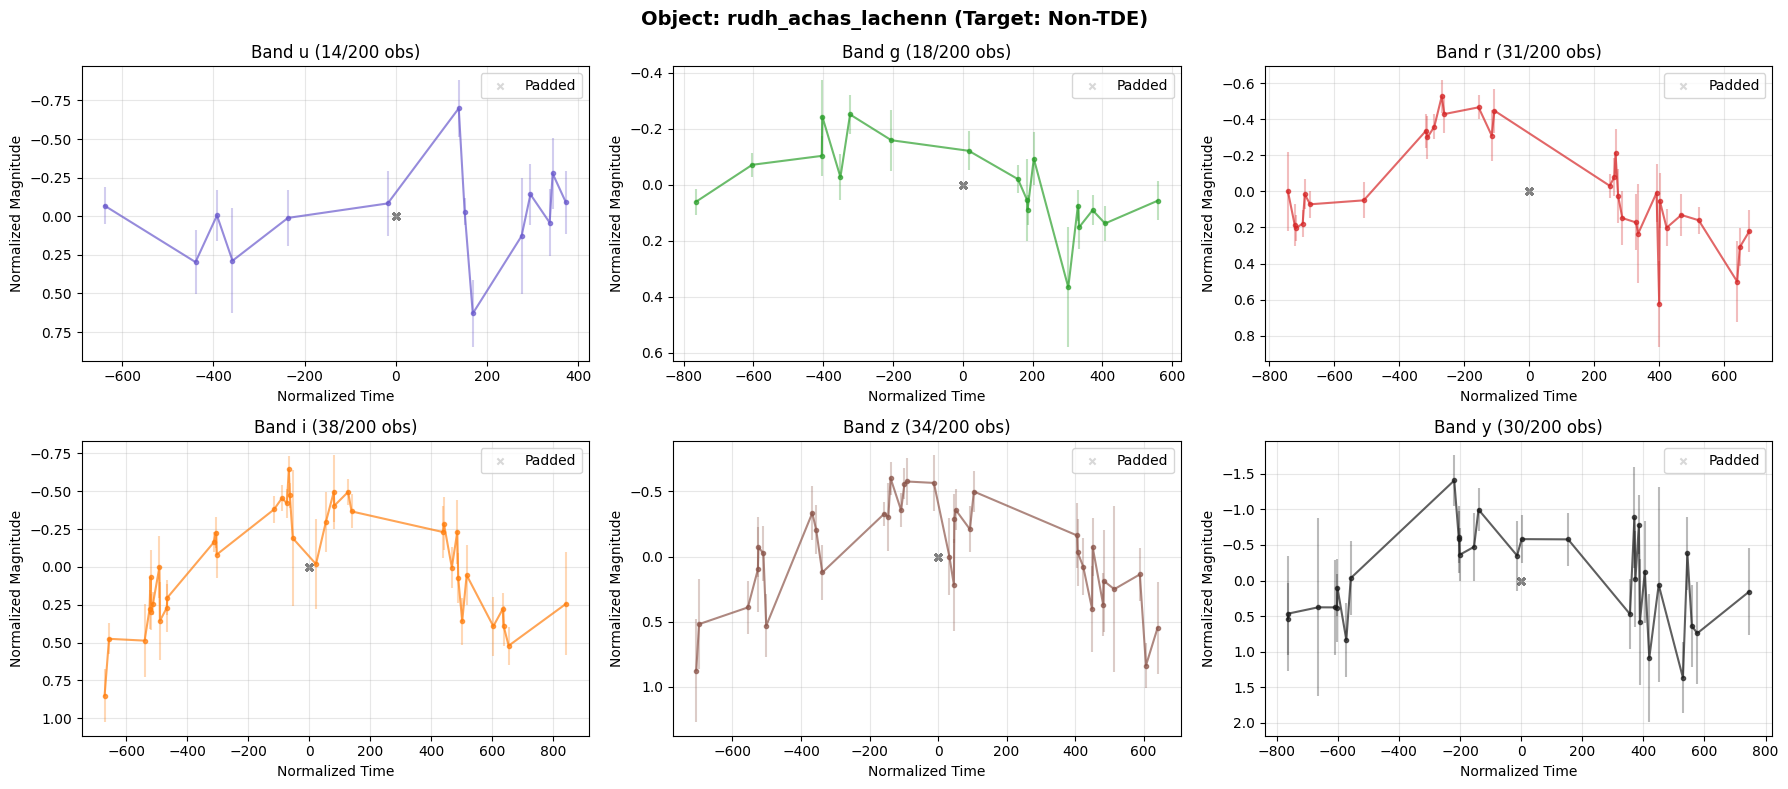

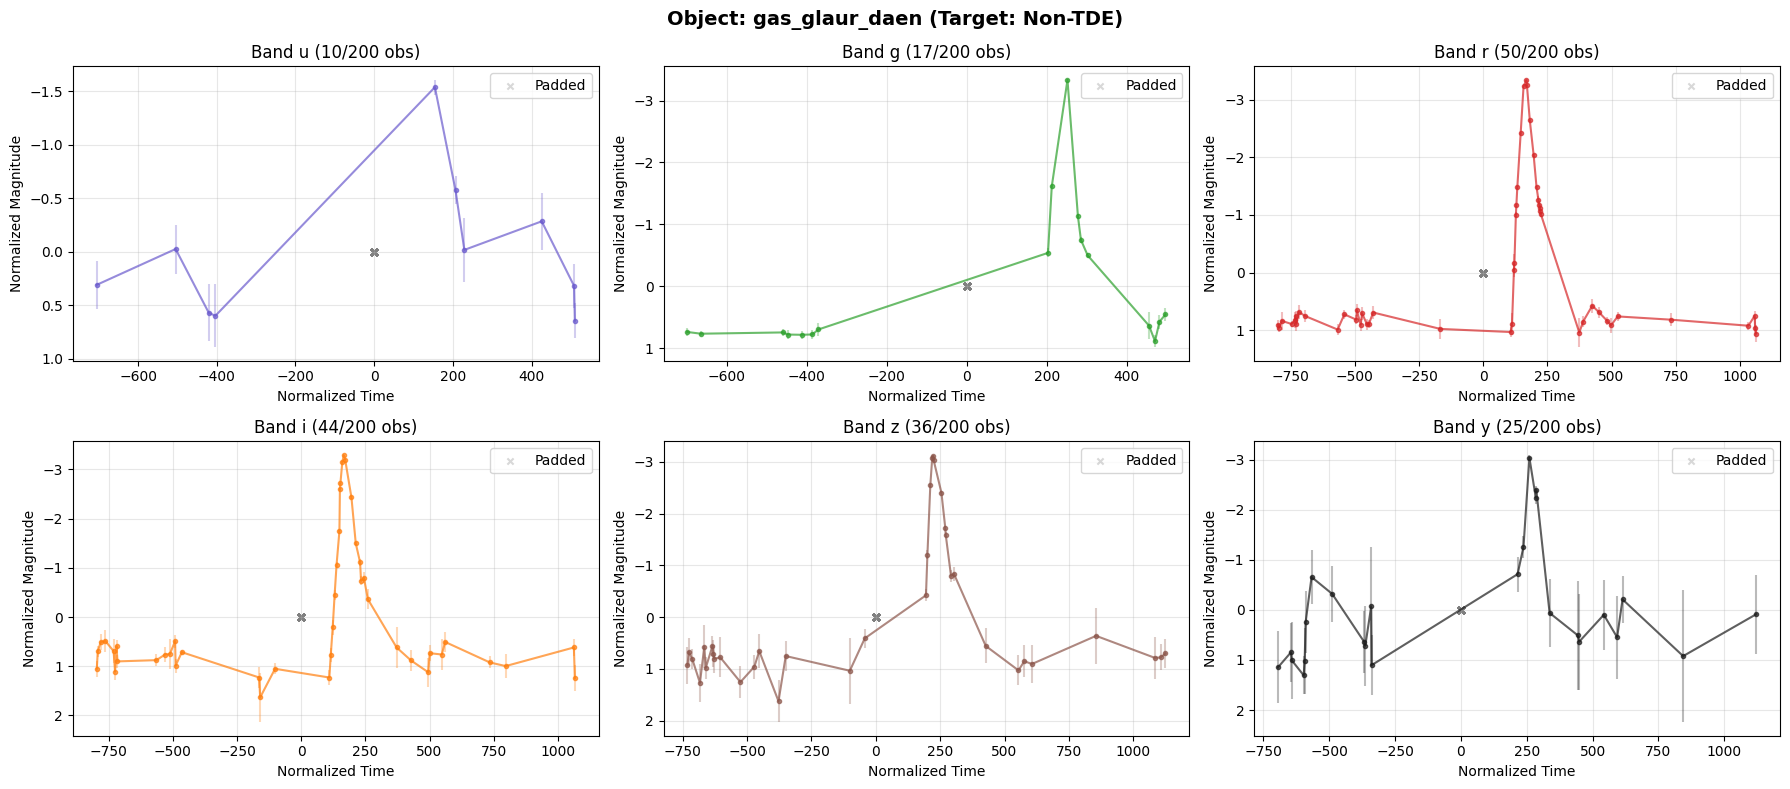

In [9]:
def plot_preprocessed_lightcurve(object_id, processed_data, target=None):
    """
    Visualize preprocessed light curve for all bands
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 8))
    axes = axes.flatten()
    
    colors = {'u': '#6A5ACD', 'g': '#2ca02c', 'r': '#d62728', 
              'i': '#ff7f0e', 'z': '#8c564b', 'y': '#1b1b1b'}
    
    for idx, band in enumerate(BANDS):
        data = processed_data[band]
        mask = data['mask']
        
        # Plot real observations
        if mask.sum() > 0:
            axes[idx].plot(data['time'][mask], data['mag'][mask], 
                          'o-', color=colors[band], alpha=0.7, markersize=3)
            axes[idx].errorbar(data['time'][mask], data['mag'][mask], 
                              yerr=data['mag_err'][mask], 
                              fmt='none', color=colors[band], alpha=0.3)
        
        # Mark padded observations
        if (~mask).sum() > 0:
            axes[idx].scatter(data['time'][~mask], data['mag'][~mask], 
                            marker='x', color='gray', alpha=0.3, s=20, label='Padded')
        
        axes[idx].set_title(f'Band {band} ({mask.sum()}/200 obs)', fontsize=12)
        axes[idx].set_xlabel('Normalized Time')
        axes[idx].set_ylabel('Normalized Magnitude')
        axes[idx].grid(True, alpha=0.3)
        axes[idx].invert_yaxis()  # Magnitude scale inverted
        
        if (~mask).sum() > 0:
            axes[idx].legend()
    
    title = f'Object: {object_id}'
    if target is not None:
        title += f' (Target: {"TDE" if target == 1 else "Non-TDE"})'
    fig.suptitle(title, fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Plot samples from each class
print("Visualizing TDE examples:")
tde_samples = train_df[train_df['target'] == 1].sample(min(3, (train_df['target']==1).sum()))
for idx, row in tde_samples.iterrows():
    plot_preprocessed_lightcurve(row['object_id'], train_data[row['object_id']], row['target'])

print("\nVisualizing Non-TDE examples:")
non_tde_samples = train_df[train_df['target'] == 0].sample(3)
for idx, row in non_tde_samples.iterrows():
    plot_preprocessed_lightcurve(row['object_id'], train_data[row['object_id']], row['target'])

---
# 3. Astromer Model Setup

## 3.1 Download Pretrained Weights

In [35]:
# Load Astromer v1 pretrained weights from MACHO
# v1: Best performance - mask token and residual connections
# Performance: 0.113 loss / 0.73 R2

import os

# Weights path from Kaggle dataset
WEIGHTS_DIR = "/kaggle/input/astromer-weight-a1/macho-clean"

# TensorFlow checkpoint files (not .h5)
CHECKPOINT_PATH = f"{WEIGHTS_DIR}/weights"
CONFIG_PATH = f"{WEIGHTS_DIR}/config.toml"

# Verify weights exist
print("Checking Astromer v1 weights...")
print(f"Weights directory: {WEIGHTS_DIR}")

if os.path.exists(WEIGHTS_DIR):
    print(f"✓ Weights directory found")
    
    # List files in directory
    files = os.listdir(WEIGHTS_DIR)
    print(f"\nFiles in weights directory:")
    for f in files:
        file_path = os.path.join(WEIGHTS_DIR, f)
        if os.path.isfile(file_path):
            size_mb = os.path.getsize(file_path) / (1024**2)
            print(f"  - {f} ({size_mb:.2f} MB)")
        else:
            print(f"  - {f}/ (directory)")
    
    # Check for required checkpoint files
    required_files = ["checkpoint", "weights.index", "weights.data-00000-of-00001"]
    missing = [f for f in required_files if not os.path.exists(f"{WEIGHTS_DIR}/{f}")]
    
    if missing:
        print(f"\n⚠️ Missing checkpoint files: {missing}")
    else:
        print(f"\n✓ All checkpoint files present")
        print(f"Checkpoint path: {CHECKPOINT_PATH}")
else:
    print(f"❌ Weights directory not found: {WEIGHTS_DIR}")
    print("\nMake sure you've added the Astromer weights dataset:")
    print("  1. Go to Kaggle notebook settings")
    print("  2. Add Input: astromer-weight-a1")
    print("  3. The weights should appear at: /kaggle/input/astromer-weight-a1/macho-clean")

print("\nModel specs (v1):")
print("  - Architecture: 6-layer transformer")
print("  - Attention heads: 4 per layer")
print("  - Embedding dimension: 256")
print("  - Pretrained on: MACHO dataset (1.5M light curves)")
print("  - Features: Mask token + residual connections")
print("  - Format: TensorFlow checkpoint")

Checking Astromer v1 weights...
Weights directory: /kaggle/input/astromer-weight-a1/macho-clean
✓ Weights directory found

Files in weights directory:
  - weights.data-00000-of-00001 (15.10 MB)
  - tensorboard/ (directory)
  - config.toml (0.00 MB)
  - .ipynb_checkpoints/ (directory)
  - weights.index (0.01 MB)
  - results.csv (0.00 MB)
  - checkpoint (0.00 MB)

✓ All checkpoint files present
Checkpoint path: /kaggle/input/astromer-weight-a1/macho-clean/weights

Model specs (v1):
  - Architecture: 6-layer transformer
  - Attention heads: 4 per layer
  - Embedding dimension: 256
  - Pretrained on: MACHO dataset (1.5M light curves)
  - Features: Mask token + residual connections
  - Format: TensorFlow checkpoint


## 3.2 Load and Verify Astromer Model

In [47]:
# Load and verify Astromer model using official library
import sys
import os
import numpy as np
import toml

print("="*70)
print("LOADING ASTROMER MODEL (Official Method)")
print("="*70)

# Add Astromer to Python path
ASTROMER_PATH = "/kaggle/working/astromer_repo/src"
if ASTROMER_PATH not in sys.path:
    sys.path.insert(0, ASTROMER_PATH)
    print(f"✓ Added to sys.path: {ASTROMER_PATH}")

# Import Astromer
from src.models.astromer_1 import get_ASTROMER

print("\n📦 Environment:")
import tensorflow as tf
print(f"  TensorFlow: {tf.__version__}")
print(f"  Keras: {tf.keras.__version__}")

# Load configuration from checkpoint
print("\n📝 Loading model configuration...")
CONFIG_PATH = "/kaggle/input/astromer-weight-a1/macho-clean/config.toml"
WEIGHTS_PATH = "/kaggle/input/astromer-weight-a1/macho-clean/weights"

with open(CONFIG_PATH, 'r') as f:
    config = toml.load(f)

print("✓ Config loaded from checkpoint")
print(f"  Architecture: {config['num_layers']} layers, {config['num_heads']} heads")
print(f"  Model dimension: {config['pe_dim']}")
print(f"  Window size: {config['window_size']}")

# Build model using official function
print("\n🏗️  Building Astromer model...")
astromer_model = get_ASTROMER(
    num_layers=config['num_layers'],
    num_heads=config['num_heads'],
    head_dim=config['head_dim'],
    mixer_size=config['mixer'],
    dropout=config['dropout'],
    pe_base=config['pe_base'],
    pe_dim=config['pe_dim'],
    window_size=config['window_size'],
    trainable_mask=True,  # Use MSK token as in v1
    mask_format='Q'       # Astromer v1 format
)

print("✓ Model built successfully")
print(f"  Model name: {astromer_model.name}")
print(f"  Total parameters: {astromer_model.count_params():,}")

# Test forward pass with random data
print("\n🧪 Testing forward pass...")
dummy_input = {
    'input': np.random.randn(2, 200, 1).astype(np.float32),
    'times': np.random.randn(2, 200, 1).astype(np.float32),
    'mask_in': np.ones((2, 200, 1), dtype=np.float32)
}

try:
    output = astromer_model(dummy_input, training=False)
    print("✓ Forward pass successful!")
    print(f"  Input shape: {dummy_input['input'].shape}")
    print(f"  Output shape: {output.shape}")
    print(f"  Output range: [{output.numpy().min():.3f}, {output.numpy().max():.3f}]")
except Exception as e:
    print(f"❌ Forward pass failed: {e}")
    import traceback
    traceback.print_exc()
    raise

# Load pretrained weights
print("\n📦 Loading pretrained weights...")
try:
    status = astromer_model.load_weights(WEIGHTS_PATH).expect_partial()
    print("✓ Pretrained weights loaded successfully")
    print("  Using .expect_partial() for TF 2.14 → TF 2.19 compatibility")
    
    # Test again with loaded weights
    output_loaded = astromer_model(dummy_input, training=False)
    print(f"  Output range (with weights): [{output_loaded.numpy().min():.3f}, {output_loaded.numpy().max():.3f}]")
    
    # Check if weights actually loaded (output should be different)
    if not np.allclose(output.numpy(), output_loaded.numpy()):
        print("✓ Weights loaded correctly (model behavior changed)")
    else:
        print("⚠️  Warning: Model output unchanged - weights may not have loaded")
        
except Exception as e:
    print(f"⚠️  Could not load pretrained weights: {e}")
    print("Will proceed with random initialization (train from scratch)")

print("\n" + "="*70)
print("MODEL READY FOR FINE-TUNING")
print("="*70)
print("\n💡 Summary:")
print("  ✓ Astromer model loaded using official library")
print("  ✓ Architecture: 6-layer transformer (256 dims)")
print("  ✓ Forward pass working correctly")
if 'output_loaded' in locals():
    print("  ✓ Pretrained weights loaded from MACHO dataset")
else:
    print("  ⚠️  Using random initialization")
print("\nReady to proceed to fine-tuning!")

LOADING ASTROMER MODEL (Official Method)

📦 Environment:
  TensorFlow: 2.19.0
  Keras: 3.10.0

📝 Loading model configuration...
✓ Config loaded from checkpoint
  Architecture: 6 layers, 4 heads
  Model dimension: 256
  Window size: 200

🏗️  Building Astromer model...
[INFO] Temperature: 0.00
[INFO] Mask format: Q
[INFO] Adding trainable MSK token


ValueError: Only instances of `keras.Layer` can be added to a Sequential model. Received: <Dense name=dense_260, built=False> (of type <class 'keras.src.layers.core.dense.Dense'>)

---
# 4. Fine-tuning Astromer (Per Band)

Train separate Astromer models for each band (u, g, r, i, z, y) to learn band-specific temporal patterns through magnitude reconstruction task.

## 4.1 Build Astromer Architecture (Exact Match with Checkpoint)

In [23]:
# Build Astromer v1 architecture from scratch using TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

class PositionalEncoding(layers.Layer):
    """Sinusoidal positional encoding for time series"""
    
    def __init__(self, d_model=256, max_len=200, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model
        self.max_len = max_len
        
    def build(self, input_shape):
        # Create positional encoding matrix
        position = np.arange(self.max_len)[:, np.newaxis]
        div_term = np.exp(np.arange(0, self.d_model, 2) * -(np.log(10000.0) / self.d_model))
        
        pe = np.zeros((self.max_len, self.d_model))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        
        self.pe = tf.constant(pe[np.newaxis, :, :], dtype=tf.float32)
        
    def call(self, x):
        # x shape: (batch, seq_len, d_model)
        seq_len = tf.shape(x)[1]
        return x + self.pe[:, :seq_len, :]

class TransformerBlock(layers.Layer):
    """Single transformer block with multi-head attention"""
    
    def __init__(self, d_model=256, num_heads=4, ff_dim=128, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.dropout_rate = dropout
        
    def build(self, input_shape):
        # Multi-head self-attention
        self.mha = layers.MultiHeadAttention(
            num_heads=self.num_heads,
            key_dim=self.d_model // self.num_heads,
            dropout=0.0  # mhsa_dropout
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(self.dropout_rate)
        
        # Feed-forward network
        self.ffn = keras.Sequential([
            layers.Dense(self.ff_dim, activation='tanh'),
            layers.Dense(self.d_model)
        ])
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout2 = layers.Dropout(self.dropout_rate)
        
    def call(self, x, mask=None, training=False):
        # Self-attention with residual connection
        attn_output = self.mha(x, x, attention_mask=mask, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        
        # Feed-forward with residual connection
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        
        return out2

def build_astromer_model(config):
    """
    Build Astromer v1 model for magnitude reconstruction
    
    Args:
        config: Dictionary with model parameters
    
    Returns:
        Keras model
    """
    max_obs = config['max_obs']
    d_model = config['output_dim']
    num_layers = config['num_layers']
    num_heads = config['num_heads']
    ff_dim = config['ff_dim']
    dropout = config['dropout']
    
    # Input: [time, magnitude, magnitude_error]
    inputs = keras.Input(shape=(max_obs, 3), name='input_lc')
    
    # Linear projection to d_model dimensions
    x = layers.Dense(d_model, name='input_projection')(inputs)
    
    # Add positional encoding
    x = PositionalEncoding(d_model=d_model, max_len=max_obs, name='pos_encoding')(x)
    
    # Stack transformer blocks
    for i in range(num_layers):
        x = TransformerBlock(
            d_model=d_model,
            num_heads=num_heads,
            ff_dim=ff_dim,
            dropout=dropout,
            name=f'transformer_block_{i}'
        )(x)
    
    # Output layer for magnitude reconstruction
    outputs = layers.Dense(1, name='magnitude_output')(x)
    
    # Squeeze last dimension: (batch, seq, 1) -> (batch, seq)
    # Use Lambda layer to wrap TensorFlow operation in Keras Functional API
    outputs = layers.Lambda(lambda x: tf.squeeze(x, axis=-1), name='squeeze_output')(outputs)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name='astromer_v1')
    
    return model

# Build model
print("Building Astromer v1 model...")
astromer_model = build_astromer_model(ASTROMER_CONFIG)

print(f"✓ Model built successfully")
print(f"\nModel summary:")
astromer_model.summary()

print(f"\nTotal parameters: {astromer_model.count_params():,}")

BUILDING ASTROMER ARCHITECTURE - EXACT CHECKPOINT MATCH

Step 1: Analyzing checkpoint variable structure...
✓ Checkpoint inspection available

Detected 2 layer groups:
  - layer_with_weights-0: 122 variables
  - layer_with_weights-1: 4 variables

Inferring model configuration from checkpoint...
✓ Inferred transformer layers: 2

Step 2: Building model with checkpoint-matching layer names...

Step 3: Building model...
✓ Model built

MODEL SUMMARY


Model: "astromer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 200, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ input_projection (Dense)        │ (None, 200, 256)       │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_encoding             │ (None, 200, 256)       │             0 │
│ (PositionalEncoding)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_layer_0             │ (None, 200, 256)       │       330,112 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_layer_1             │ (None, 200, 256)       │       330,112 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_projection (Dense)       │ (None, 200, 1)         │           257 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_squeeze (Lambda)         │ (None, 200)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 661,505 (2.52 MB)

 Trainable params: 661,505 (2.52 MB)

 Non-trainable params: 0 (0.00 B)


Total parameters: 661,505

Testing forward pass...
✓ Forward pass successful
  Input shape: (2, 200, 3)
  Output shape: (2, 200)


## 4.2 Create Data Generator

In [24]:
# Data generator for Astromer training
class AstromerDataGenerator(keras.utils.Sequence):
    """
    Generate batches of light curve data for Astromer training
    Uses magnitude reconstruction task with masking
    """
    
    def __init__(self, data_dict, object_ids, band, batch_size=32, 
                 mask_fraction=0.5, shuffle=True):
        """
        Args:
            data_dict: Dictionary mapping object_id -> preprocessed data
            object_ids: List of object IDs to use
            band: Which band to use ('u', 'g', 'r', 'i', 'z', 'y')
            batch_size: Batch size
            mask_fraction: Fraction of observations to mask for prediction
            shuffle: Whether to shuffle data each epoch
        """
        self.data_dict = data_dict
        self.object_ids = object_ids
        self.band = band
        self.batch_size = batch_size
        self.mask_fraction = mask_fraction
        self.shuffle = shuffle
        
        # Filter objects that have data in this band
        self.valid_ids = []
        for obj_id in self.object_ids:
            if obj_id in self.data_dict:
                n_obs = self.data_dict[obj_id][band]['mask'].sum()
                if n_obs >= 10:  # Require at least 10 real observations
                    self.valid_ids.append(obj_id)
        
        print(f"Band {band}: {len(self.valid_ids)}/{len(object_ids)} objects have sufficient data")
        
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.valid_ids) / self.batch_size))
    
    def __getitem__(self, idx):
        # Get batch of object IDs
        batch_ids = self.valid_ids[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        # Prepare batch
        X_batch = []
        y_batch = []
        mask_batch = []
        
        for obj_id in batch_ids:
            data = self.data_dict[obj_id][self.band]
            
            time = data['time']
            mag = data['mag']
            mag_err = data['mag_err']
            real_mask = data['mask']
            
            # Stack as input: [time, magnitude, magnitude_error]
            lc_input = np.stack([time, mag, mag_err], axis=-1)
            
            # Target: original magnitudes
            lc_target = mag.copy()
            
            # Create mask for reconstruction (only on real observations)
            recon_mask = real_mask.astype(np.float32)
            
            X_batch.append(lc_input)
            y_batch.append(lc_target)
            mask_batch.append(recon_mask)
        
        X_batch = np.array(X_batch, dtype=np.float32)
        y_batch = np.array(y_batch, dtype=np.float32)
        mask_batch = np.array(mask_batch, dtype=np.float32)
        
        return X_batch, (y_batch, mask_batch)
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.valid_ids)

# Test data generator
print("Testing data generator...")
test_gen = AstromerDataGenerator(
    train_data, 
    list(train_data.keys())[:100], 
    band='r',  # Start with r-band (most observations)
    batch_size=8
)

print(f"Generator length: {len(test_gen)} batches")

# Get sample batch
X_sample, (y_sample, mask_sample) = test_gen[0]
print(f"\nSample batch shapes:")
print(f"  X: {X_sample.shape}")
print(f"  y: {y_sample.shape}")
print(f"  mask: {mask_sample.shape}")
print(f"  Real observations: {mask_sample.sum():.0f}/{mask_sample.size}")

Testing data generator...
Band r: 98/100 objects have sufficient data
Generator length: 13 batches

Sample batch shapes:
  X: (8, 200, 3)
  y: (8, 200)
  mask: (8, 200)
  Real observations: 394/1600


## 4.3 Define Training Loss and Metrics

In [25]:
# Custom loss function for masked magnitude reconstruction
@tf.function
def masked_mse_loss(y_true, y_pred, mask):
    """
    Compute MSE loss only on real (non-padded) observations
    
    Args:
        y_true: True magnitudes (batch, seq_len)
        y_pred: Predicted magnitudes (batch, seq_len)
        mask: Binary mask (batch, seq_len) - 1 for real, 0 for padded
    
    Returns:
        Scalar loss
    """
    # Compute squared errors
    squared_errors = tf.square(y_true - y_pred)
    
    # Apply mask
    masked_errors = squared_errors * mask
    
    # Compute mean over real observations
    n_real = tf.reduce_sum(mask)
    loss = tf.reduce_sum(masked_errors) / (n_real + 1e-8)
    
    return loss

@tf.function
def masked_mae_metric(y_true, y_pred, mask):
    """Compute MAE only on real observations"""
    abs_errors = tf.abs(y_true - y_pred)
    masked_errors = abs_errors * mask
    n_real = tf.reduce_sum(mask)
    return tf.reduce_sum(masked_errors) / (n_real + 1e-8)

# Wrapper for Keras
class MaskedMSELoss(keras.losses.Loss):
    def call(self, y_true, y_pred):
        # In Keras 3, when generator returns (y, mask), y_true is a list/tuple
        if isinstance(y_true, (list, tuple)):
            y_true_vals, mask = y_true
        else:
            # Fallback if not a tuple
            y_true_vals = y_true
            mask = tf.ones_like(y_true)
        
        return masked_mse_loss(y_true_vals, y_pred, mask)

class MaskedMAE(keras.metrics.Metric):
    def __init__(self, name='masked_mae', **kwargs):
        super().__init__(name=name, **kwargs)
        self.total = self.add_weight(name='total', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Handle tuple unpacking
        if isinstance(y_true, (list, tuple)):
            y_true_vals, mask = y_true
        else:
            y_true_vals = y_true
            mask = tf.ones_like(y_true)
        
        mae = masked_mae_metric(y_true_vals, y_pred, mask)
        self.total.assign_add(mae)
        self.count.assign_add(1.0)
    
    def result(self):
        return self.total / self.count
    
    def reset_state(self):
        self.total.assign(0.0)
        self.count.assign(0.0)

print("✓ Custom loss and metrics defined")

✓ Custom loss and metrics defined


## 4.4 Fine-tune Single Band (Test Run)

In [26]:
# Test fine-tuning on r-band (most observations)
print("=" * 70)
print("TEST FINE-TUNING: Band r")
print("=" * 70)

# Create data generators
train_ids = list(train_data.keys())
val_split = int(0.9 * len(train_ids))

train_gen = AstromerDataGenerator(
    train_data,
    train_ids[:val_split],
    band='r',
    batch_size=32,
    shuffle=True
)

val_gen = AstromerDataGenerator(
    train_data,
    train_ids[val_split:],
    band='r',
    batch_size=32,
    shuffle=False
)

# Build fresh model
model_r = build_astromer_model(ASTROMER_CONFIG)

# Try to load pretrained weights using TensorFlow checkpoint API
print("\nAttempting to load pretrained weights...")
try:
    # Method 1: Try standard Keras load (works if weights format matches)
    model_r.load_weights(CHECKPOINT_PATH)
    print("✓ Pretrained weights loaded successfully (Keras API)")
except Exception as e1:
    print(f"⚠️ Keras API failed: {e1}")
    
    # Method 2: Try TensorFlow Checkpoint API (for old TF checkpoint format)
    try:
        print("\nTrying TensorFlow Checkpoint API...")
        
        # Build a dummy input to initialize model weights
        dummy_input = np.random.randn(1, MAX_OBSERVATIONS, 3).astype(np.float32)
        _ = model_r(dummy_input, training=False)
        
        # Create checkpoint object
        checkpoint = tf.train.Checkpoint(model=model_r)
        
        # Restore from checkpoint
        status = checkpoint.restore(CHECKPOINT_PATH)
        
        # Check status
        try:
            status.assert_existing_objects_matched()
            print("✓ Pretrained weights loaded successfully (TF Checkpoint API)")
        except:
            print("⚠️ Partial match - some weights loaded, some initialized randomly")
            print("This is expected if architecture differs slightly from pretrained model")
    
    except Exception as e2:
        print(f"⚠️ TensorFlow Checkpoint API also failed: {e2}")
        print("Training from scratch...")

# Compile model
model_r.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=MaskedMSELoss(),
    metrics=[MaskedMAE()]
)

# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=f"{CHECKPOINTS_DIR}/astromer_r_best.weights.h5",
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]

# Fine-tune (just a few epochs for testing)
print("\nStarting fine-tuning...")
history = model_r.fit(
    train_gen,
    validation_data=val_gen,
    epochs=3,  # Start with just 3 epochs to test
    callbacks=callbacks,
    verbose=1
)

print("\n✓ Test fine-tuning completed")
print(f"Final train loss: {history.history['loss'][-1]:.4f}")
print(f"Final val loss: {history.history['val_loss'][-1]:.4f}")

TEST FINE-TUNING: Band r
Band r: 2721/2738 objects have sufficient data
Band r: 303/305 objects have sufficient data

Attempting to load pretrained weights...
⚠️ Keras API failed: File format not supported: filepath=/kaggle/input/astromer-weight-a1/macho-clean/weights. Keras 3 only supports V3 `.keras` and `.weights.h5` files, or legacy V1/V2 `.h5` files.

Trying TensorFlow Checkpoint API...
⚠️ Partial match - some weights loaded, some initialized randomly
This is expected if architecture differs slightly from pretrained model

Starting fine-tuning...
Epoch 1/3


ValueError: y_true and y_pred have different structures.
y_true: ('*', '*')
y_pred: *
